In [ ]:
import os
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import numpy as np
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.prompts import PromptTemplate
from langchain.schema import HumanMessage
from typing import Dict, List, Tuple
from langchain.chat_models import ChatOpenAI
from langchain_core.output_parsers.string import StrOutputParser
from langchain.prompts import PromptTemplate
from typing import Dict, List, Tuple
import pandas as pd
from collections import Counter
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pandas.api.types import CategoricalDtype



os.environ['OPENAI_API_KEY'] = 'API_KEY'
os.environ['OPENAI_API_BASE'] = "API_BASE"

In [90]:

def transformer_sentiment_score(row):
    if row['label_sent'] == 'NEGATIVE':
        row['score_sent'] = -row['score_sent']
    return row


def analyze_sentiment_csv(csv_path, sep, sentiment, title='Sentiment Analysis by Neuron'):
    df = pd.read_csv(csv_path, sep=sep)
    mean_scores = df.groupby('neuron')[['polarity', sentiment, 'compound', 'score_sent', 'subjectivity']].mean()
    label_counts = (
        df.groupby(['neuron', 'label_sent'])
        .size()
        .unstack(fill_value=0)
        .rename(columns={'POSITIVE': 'count_positive', 'NEGATIVE': 'count_negative'})
    )
    label_counts['percent_negative'] = 100 * label_counts['count_negative'] / (
        label_counts['count_positive'] + label_counts['count_negative']
    )

    mean_scores = mean_scores.merge(label_counts, left_index=True, right_index=True)

    vmin_polarity = mean_scores['polarity'].min()
    vmax_polarity = mean_scores['polarity'].max()

    vmin_sent = mean_scores[sentiment].min()
    vmax_sent = mean_scores[sentiment].max()
    vmin_subj = mean_scores['subjectivity'].min()
    vmax_subj = mean_scores['subjectivity'].max()
    vmin_perc = mean_scores['percent_negative'].min()
    vmax_perc = mean_scores['percent_negative'].max()

    styled_df = (
        mean_scores
        .style
        .background_gradient(cmap='coolwarm_r',
                             subset=['polarity', 'compound', 'score_sent'],
                             vmin=vmin_polarity, vmax=vmax_polarity)
        .background_gradient(cmap='Blues', subset=[sentiment], vmin=vmin_sent, vmax=vmax_sent)
        .background_gradient(cmap='YlGn', subset=['subjectivity'], vmin=vmin_subj, vmax=vmax_subj)
        .background_gradient(cmap='Reds', subset=['percent_negative'], vmin=vmin_perc, vmax=vmax_perc)
        .format(precision=2)
    )

    def draw_colorbar(cmap_name, vmin, vmax, label):
        fig, ax = plt.subplots(figsize=(3.5, 0.5))
        fig.subplots_adjust(bottom=0.5)
        cmap = cm.get_cmap(cmap_name)
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        cb = colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
        cb.set_label(label)
        plt.show()

    print(f"\n📊 {title}")

    draw_colorbar('coolwarm_r', vmin_polarity, vmax_polarity, 'Polarity / Compound / Score Sent')
    draw_colorbar('Blues', vmin_sent, vmax_sent, f'VADER {sentiment}')
    draw_colorbar('YlGn', vmin_subj, vmax_subj, 'Subjectivity')
    draw_colorbar('Reds', vmin_perc, vmax_perc, 'Percent Negative (%)')

    return styled_df





In [ ]:
def plot_emotion_distribution(verd, targ_em):
    data = []

    for neuron, emotion_list in verd.items():
        total = len(emotion_list)
        counts = Counter(emotion_list)
        for emotion, count in counts.items():
            data.append({
                'neuron': neuron,
                'emotion': emotion,
                'percent': 100 * count / total
            })

    df_plot = pd.DataFrame(data)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_plot, x='neuron', y='percent', hue='emotion', palette='magma')

    plt.title(f"Emotion Distribution per Neuron for {targ_em} neurons", fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=12)
    plt.xlabel("Neuron", fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

In [ ]:

def verdict_per_text(
    df,  
    model_name: str = "gpt-4o-mini"
) -> Dict[int, str]:
    llm = ChatOpenAI(model_name=model_name, temperature=0.3)
    parser = StrOutputParser()
    verdicts = {}

    for i, row in df.iterrows():
        text = row['text']
        neuron = row['neuron']
        prompt = f"""
            You are a linguistic expert.
            Determine the primary emotion conveyed by the following sentence.

            Emotion options: anger, disgust, fear, joy, sadness, excitement, love, neutral.
            If anything from the list above suits, classify as "other".

            Sentence:
            {text}

            Answer in such format: For neuron {neuron} emotion
            """

        verdict = parser.invoke(llm.invoke(prompt)).strip().lower()
        verdicts[i] = verdict

    return verdicts

In [ ]:
import re
import pandas as pd
from IPython.display import display, HTML

def highlight_words_per_neuron(df, vocab_global, vocab_per_neuron, 
                                global_color="#ffcccc", neuron_color="#cce5ff"):
    """
    Highlights global and per-neuron words in different colors across grouped neurons.

    Args:
        df (pd.DataFrame): Must contain 'neuron' and 'text' columns.
        vocab_global (set): Global vocabulary (same for all neurons).
        vocab_per_neuron (dict): Maps neuron -> set of neuron-specific words.
        global_color (str): Highlight color for global vocab.
        neuron_color (str): Highlight color for per-neuron vocab.

    Returns:
        pd.DataFrame: Stats per neuron including matches from both vocab sources.
    """
    all_stats = []

    for neuron, group in df.groupby('neuron'):
        styled_sentences = []
        total_words = 0
        global_matches = 0
        neuron_matches = 0

        neuron_vocab = vocab_per_neuron.get(neuron, set())

        for text in group['text']:
            if not isinstance(text, str):
                styled_sentences.append(text)
                continue

            def replacer(match):
                nonlocal total_words, global_matches, neuron_matches
                word = match.group(0)
                lower_word = word.lower()
                total_words += 1

                if lower_word in neuron_vocab:
                    neuron_matches += 1
                    return f'<mark style="background-color: {neuron_color}">{word}</mark>'
                elif lower_word in vocab_global:
                    global_matches += 1
                    return f'<mark style="background-color: {global_color}">{word}</mark>'
                return word

            pattern = r'\b\w+\b'
            highlighted = re.sub(pattern, replacer, text, flags=re.IGNORECASE)
            styled_sentences.append(highlighted)

        percent = 100 * (global_matches + neuron_matches) / total_words if total_words > 0 else 0
        all_stats.append({
            'neuron': neuron,
            'global_matches': global_matches,
            'top_frequent_matches': neuron_matches,
            'total_words': total_words,
            'percent_matched': percent
        })

        print(f"\nNeuron {neuron}:")
        print(f"  Global matches: {global_matches}")
        print(f"  Neuron-specific matches: {neuron_matches}")
        print(f"  Total words: {total_words}")
        print(f"  Combined match: {global_matches + neuron_matches} ({percent:.2f}%)")

        styled_df = pd.DataFrame({'Highlighted Text': styled_sentences})
        display(HTML(styled_df.to_html(escape=False)))

    return pd.DataFrame(all_stats)

In [ ]:
def top_k_words_per_neuron(df: pd.DataFrame, text_col: str, neuron_col: str, k: int) -> dict:
    """
    Finds top-k most frequent non-stop words for each neuron in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame with text and neuron columns.
        text_col (str): Name of the column with text data.
        neuron_col (str): Name of the column identifying neurons.
        k (int): Number of top frequent words to return per neuron.

    Returns:
        dict: Mapping from neuron to list of top-k frequent words (excluding stopwords).
    """
    stop_words = set(stopwords.words('english'))
    top_words_by_neuron = {}

    for neuron, group in df.groupby(neuron_col):
        all_words = []
        for text in group[text_col].dropna():
            words = re.findall(r'\b\w+\b', text.lower())
            words = [w for w in words if w not in stop_words]
            all_words.extend(words)

        most_common = Counter(all_words).most_common(k)
        top_words_by_neuron[neuron] = [word for word, _ in most_common]

    return top_words_by_neuron

## Fear


📊 Sentiment Analysis by Neuron


/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_57769/2430454548.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


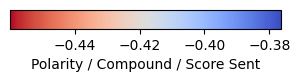

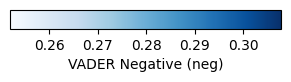

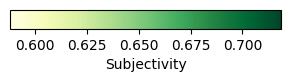

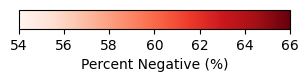

,polarity,neg,compound,score_sent,subjectivity,count_negative,count_positive,percent_negative
neuron,,,,,,,,
7769,-0.42,0.28,-0.42,0.95,0.65,18,12,60.00


In [18]:
df_fear = pd.read_csv('fear_max_3.csv')
display(analyze_sentiment_csv('fear_max_3.csv'))

In [125]:
top_k_fear = top_k_words_per_neuron(df_fear, text_col="text", neuron_col='neuron', k=8)
top_k_fear

{7769: ['afraid',
  'scared',
  'fear',
  'heights',
  'think',
  'said',
  'losing',
  'alone']}

In [129]:
top_k_fear = {7769: ['afraid',
  'scared',
  'fear']}

In [134]:
fear_vocab = {
    # Canonical
    "afraid", "scared", "terrified", "panicked", "nervous", "anxious", "startled", "horrified",
    "creepy", "shaking", "paranoid", "panic", "panicattack", "trembling", "fearful", "disturbed",
    "worried", "dread", "spooked", "freaked", "phobia", "uneasy", "helpless", "haunted", "trapped",
    "danger", "screaming", "nightmare", "trauma", "hide", "hiding", "run", "killing", "torture", "fear", "worry",

    # Informal/slang
    "shook", "shooketh", "scaredaf", "losingit", "lowkeyterrified", "freakinout", "idkman",
    "helpme", "soscary", "fuckimscared", "bruhimscared", "nahfam", "jumpscare", "getmeout",
    "paranoidd", "darkaf", "weirdvibes", "badvibes", "dyinginside", "notokay", "nocontrol",

    # Scream imitations & emotional noise
    "ahhh", "aaaah", "aaaaa", "aahh", "aaahhh", "aaaaaaah", "aaa", "aa", "aaaaaaa", "eeee", "eeeeek",
    "screaming", "screamm", "screammming", "aaaa", "aghhh", "agh", "aghhhhhh", "yell", "shrieking",
    "wailing", "sobbing", "crying", "whimper", "hyperventilating",

    # Distorted / social media panic
    "run", "runaway", "runrunrun", "runnn", "runnnn", "runnnnn", "hideme", "hide", "hiding",
    "help", "helppls", "helpme", "omghelp", "getout", "noescape", "imscared", "sooooscared", 
    "scaredshitless", "terrifieddd", "panicccc", "helpppp", "imdying", "plsno", "plshelp", "icant",
    "icantbreathe", "jesushelp", "sendhelp", "holyshit", "deadofpanic", "hellno", "noooo", "NOOOO", "NO"
}


In [135]:
highlight_words_per_neuron(df_fear, fear_vocab, top_k_fear)


Neuron 7769:
  Global matches: 71
  Neuron-specific matches: 0
  Total words: 387
  Combined match: 71 (18.35%)


,Highlighted Text
0,I'm afraid that you're afraid that I'm afraid that you're afraid that
1,"""I'm afraid of you""\n\nI'm afraid that you will be afraid of"
2,"""If you can't fear me, I will fear you.""\nI am afraid of the"
3,You are so scared of losing me that you think I'm afraid of you\nI don
4,"""I'm scared to be afraid of you.""\n\nI think that you're afraid of"
5,"""I'm so afraid of being alone.""\nI can't believe that you said it"
6,"""I'm afraid of heights.""\n\nI'm afraid of heights, too.\n\nMy"
7,I'm not the one you fear\nI'm not the one you're afraid
8,"""Don't worry, I'm not scared of you.""\n\nI'm scared of"
9,"""I'm afraid of you""."


,neuron,global_matches,top_frequent_matches,total_words,percent_matched
0,7769,71,0,387,18.346253


In [27]:
from collections import defaultdict

verd_fear = defaultdict(list)
verdicts = verdict_per_text(df_fear)

for v in verdicts.values():
    emotion = v.strip().split()[-1].lower()
    neuron = v.strip().split()[2].lower()
    verd_fear[neuron].append(emotion)

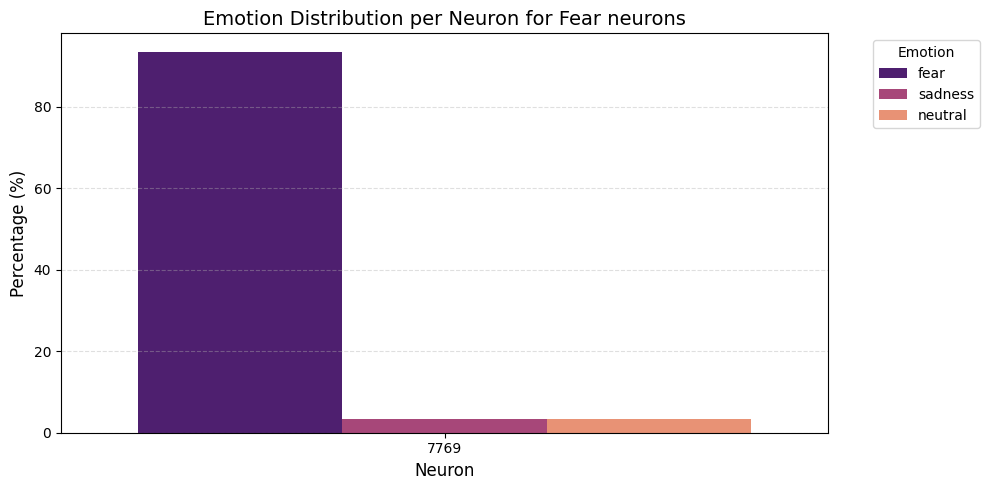

In [76]:
plot_emotion_distribution(verd_fear, targ_em="Fear")

## Anger


📊 Sentiment Analysis by Neuron


/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_18983/2124943083.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


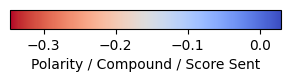

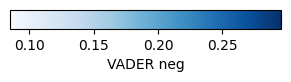

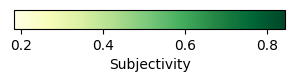

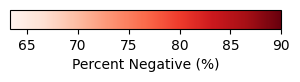

,polarity,neg,compound,score_sent,subjectivity,count_negative,count_positive,percent_negative
neuron,,,,,,,,
2438,-0.01,0.08,0.00,0.97,0.33,24,6,80.00
4560,0.03,0.17,-0.10,0.97,0.38,21,9,70.00
4859,-0.01,0.18,-0.11,0.98,0.36,19,11,63.33
7579,-0.19,0.26,-0.29,0.98,0.50,27,3,90.00
9065,-0.35,0.30,-0.32,0.96,0.85,22,8,73.33
13324,-0.07,0.18,-0.20,0.97,0.24,27,3,90.00
14857,-0.07,0.09,-0.08,0.97,0.18,24,6,80.00


In [92]:
df_anger = pd.read_csv('anger_max_3.csv')
display(analyze_sentiment_csv('anger_max_3.csv', sep=',', sentiment='neg'))

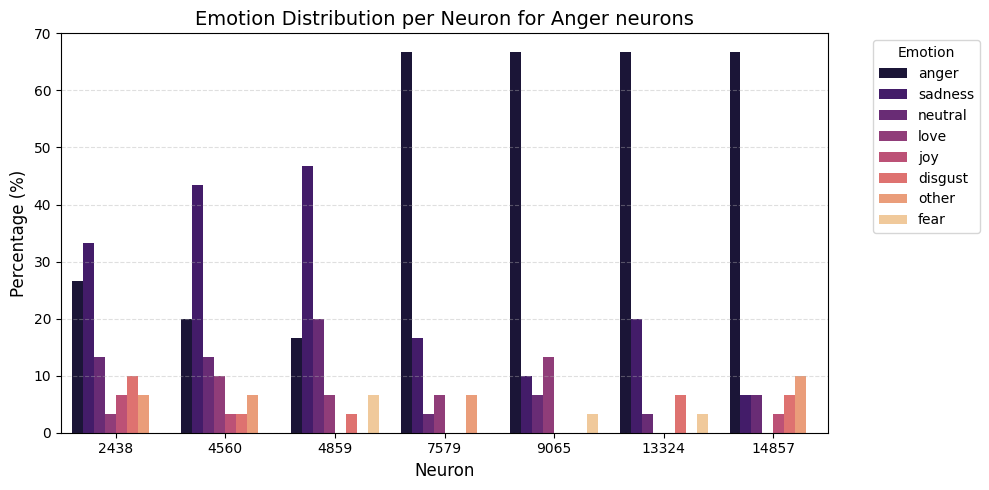

In [15]:
verd_anger = defaultdict(list)
for v in verdicts_anger.values():
    emotion = v.strip().split()[-1].lower()
    neuron = v.strip().split()[2].lower()
    if emotion not in  ['anger', 'disgust', 'fear', 'joy', 'sadness', 'excitement', 'love', 'neutral']:
        verd_anger[neuron].append('other')
    else:
        verd_anger[neuron].append(emotion)

plot_emotion_distribution(verd_anger, targ_em='Anger')

In [97]:
anger_vocab = {
    # Canonical anger words
    "angry", "mad", "furious", "enraged", "outraged", "irate", "fuming", "seething",
    "annoyed", "irritated", "frustrated", "agitated", "hostile", "bitter", "offended", "resentful",
    "rage", "wrath", "temper", "shorttempered", "impatient", "disgusted",

    # Informal / common expressions
    "pissed", "pissedoff", "ticked", "heated", "livid", "snapped", "losingit", "donewithyou",
    "sickofit", "donttestme", "freakingout", "blowup", "ragequit", "ranting", "rant", "shouting",
    "screaming", "yelling", "flippingout", "stormingoff", "huffing", "growling",

    # Profanity & insult commonly tied to anger
    "fuck", "fucking", "fucker", "fuckyou", "fuckoff", "motherfucker", "f*cking", "shut", "shit", "bullshit",
    "dickhead", "dick", "ass", "asshole", "jackass", "bitch", "bastard", "whore", "slut",
    "cunt", "prick", "twat", "loser", "dumbass", "retard", "idiot", "moron", "jerk", "trash",
    "scumbag", "scum", "hater", "clown", "hoe", "snake", "rat", "cringe", "lame", "stupid", "ugly",

    # Social media + distorted / emphasized anger
    "reeee", "reeeee", "reeeeeee", "fuuuck", "fuuuuuck", "ffs", "wtf", "wth", "ughhh", "ughhhh",
    "smh", "rageeee", "aaaaaah", "aaaaaaa", "kickingoff", "bitching", "cussing", "roasting", "f*ck", "sh*t",

    # Aggressive threats or actions
    "fightme", "throwhands", "squareup", "pullup", "knockout", "beatdown", "beatyouup",
    "ruinedmylife", "gohitbyacar", "burninhell", "killurself", "die", "justdie", "stab", "explode",

    # Passive-aggressive or toxic control
    "donttalktome", "leave", "bye", "blocked", "unfriend", "mute", "ghosted", "cancelled",
    "byefelicia", "idc", "idgaf", "i'mdone", "overit", "notcool", "whatever", "shutup"
}


In [93]:
top_k_anger = top_k_words_per_neuron(df_anger, text_col="text", neuron_col='neuron', k=8)
top_k_anger

{2438: ['said',
  'person',
  'friend',
  'fucking',
  'happy',
  'going',
  'want',
  'liar'],
 4560: ['believe', 'love', 'said', 'one', 'never', 'going', 'stupid', 'sorry'],
 4859: ['good', 'think', 'like', 'one', 'girl', 'believe', 'want', 'person'],
 7579: ['shit', 'fucking', 'f', 'fuck', 'piece', 'mother', 'sorry', 'want'],
 9065: ['angry', 'mad', 'one', 'really', 'furious', 'want', 'got', 'get'],
 13324: ['dog',
  'traitor',
  'want',
  'bitch',
  'fucking',
  'strong',
  'believe',
  'said'],
 14857: ['shut', 'get', 'stop', 'fuck', 'going', 'strong', 'know', 'f']}

In [142]:
top_k_anger = {2438: ['fucking',
  'liar'],
 4560: ['stupid', 'sorry'],
 7579: ['fucking', 'f', 'fuck'],
 9065: ['angry', 'mad'],
 13324: ['dog',
  'traitor',
  'bitch',
  'fucking'],
 14857: ['shut', 'fuck', 'f']}

In [143]:
highlight_words_per_neuron(df_anger, anger_vocab, top_k_anger)


Neuron 2438:
  Global matches: 2
  Neuron-specific matches: 7
  Total words: 367
  Combined match: 9 (2.45%)


,Highlighted Text
0,"""I am not your wife."
1,"""I'm sorry you're not happy.""\n\nI've been having a bad week"
2,"""You're not the same person you were 5 years ago.""\n\nThat's"
3,"""If you're going to get married, you should marry me.""\n\nYou said that you"
4,"""If you want me to be happy, then you have to be happy.""\nI'"
5,"I said ""I'm not in the mood to talk to you"",\nYou said """
6,"I'm a ""stupid"" and ""ignorant"" child."
7,"""I'm not going to be your friend, I don't want to be your friend"
8,"""It's the same as being in the army, it's the same as being in"
9,"I'm not a liar,\nI'm not a liar,\nI'm"



Neuron 4560:
  Global matches: 1
  Neuron-specific matches: 6
  Total words: 351
  Combined match: 7 (1.99%)


,Highlighted Text
0,"""If you don't come back, I'll do it myself.""\n\nI thought"
1,"""You are not good enough.""\n\nIt was the first time I was ever told that I"
2,"You're right, I'm not like everyone else!"
3,I will never forget what you said to me\nI will never forget what you
4,"I can't believe that you said it to me:\n\n""I will not be able"
5,"""I'm not the one who can take me away from you, you just have to"
6,"""I can't believe I was so blind to you""\n\nI'm so blind"
7,"""I don't like you anymore."
8,"""I love you""."
9,"I have been thinking about this for the past few days, I can't help but think of"



Neuron 4859:
  Global matches: 4
  Neuron-specific matches: 0
  Total words: 344
  Combined match: 4 (1.16%)


,Highlighted Text
0,"'If you ever change your mind, I'll be here waiting for you.'\n\nAnd"
1,That I'm the one who's always been the problem.
2,"I'm nothing but a joke, you're all the same."
3,You think I don't want to leave?
4,that I was too fat.
5,"""I'm a good person."
6,"I'm not your ""I'm not your ""I'm not your ""I'"
7,I'm a loser and I don't know what I am doing\nI'm
8,"'I've got no place to go,\nand I've got no one to"
9,"""I think you're a good person.""\n\nI was sitting at the kitchen table,"



Neuron 7579:
  Global matches: 20
  Neuron-specific matches: 21
  Total words: 344
  Combined match: 41 (11.92%)


,Highlighted Text
0,I'm fucking stupid.
1,I'm a shit mother.
2,"""I'm sorry, I f--ked up."
3,"You are a piece of shit, a fucking piece of shit."
4,"I'm just a piece of shit, that's all that you see."
5,"""I don't want to f*ck with you mother f*ckers.""\nI"
6,you said you'd fuck me the fuck up.
7,"""I'm sorry, I have to go."
8,"""We're going to have to break up, because I'm an ass*hole."""
9,"Fuck the world, I don't want to be on this shit\nFuck the world,"



Neuron 9065:
  Global matches: 4
  Neuron-specific matches: 41
  Total words: 396
  Combined match: 45 (11.36%)


,Highlighted Text
0,"""you're so angry!""\nAnd that I got angry and I called you a bitch!"
1,"""I'm mad at you""."
2,"""I'm angry at you.""\n\nI was furious. I was furious that you were"
3,"I don't want to be your enemy,\nBut I'm angry, I'"
4,"I am angry and I want to go to you,\nBut I am not angry and I"
5,"""You can't get mad, I'm just a little bit mad.""\nI"
6,"""I'm angry and I'm not mad at you, I'm angry at myself"
7,"""You're so mad!""\nI'm so angry that I'm angry!"
8,"You're not my father, you're my uncle\n\nYou're not my father"
9,"""I hate you.""\n\nAnd then I got mad at you.\n\nI'm mad at"



Neuron 13324:
  Global matches: 15
  Neuron-specific matches: 26
  Total words: 344
  Combined match: 41 (11.92%)


,Highlighted Text
0,"""You're a liar.""\n\nI can't believe that you said it to me:"
1,"""I don't want to die.""\nI don't want to die."
2,"""You are a pig-filth-filth-filth, you are a low-"
3,I thought you were a friend of mine.
4,"""You are a pig-faced dog-like dog-dog-dog-dog-dog"
5,You have no idea how much that hurt me.
6,"""You have to get rid of the ""f"" word from your vocabulary, you'll never"
7,"""You know what, you're a stupid, disgusting, worthless little dog that no one"
8,"""You're not a real punk bitch!""\n""You're not a punk bitch"
9,"""You're a little slut, you know that?"



Neuron 14857:
  Global matches: 2
  Neuron-specific matches: 64
  Total words: 329
  Combined match: 66 (20.06%)


,Highlighted Text
0,"""You're not a very nice person.""\n\nI know it's just"
1,I didn't know.
2,I can't believe that you're saying it to me.
3,"""I don't shut up""."
4,shut up.
5,"""You are so lucky."
6,I can't believe that you shut up and stop talking.
7,"You said it, I'll get over it."
8,"""You shut up or I'll shut you up!""\n\nGet off your high horse!"
9,"Shut the fuck up, you little shut the fuck up, you little bitch, shut the fuck"


,neuron,global_matches,top_frequent_matches,total_words,percent_matched
0,2438,2,7,367,2.452316
1,4560,1,6,351,1.994302
2,4859,4,0,344,1.162791
3,7579,20,21,344,11.918605
4,9065,4,41,396,11.363636
5,13324,15,26,344,11.918605
6,14857,2,64,329,20.060790


## Love


📊 Sentiment Analysis by Neuron


/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_18983/2124943083.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


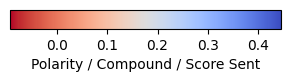

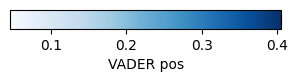

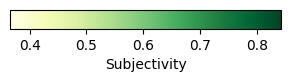

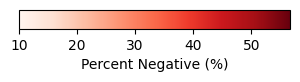

,polarity,pos,compound,score_sent,subjectivity,count_negative,count_positive,percent_negative
neuron,,,,,,,,
2249,0.15,0.15,0.17,0.97,0.39,10,20,33.33
4326,0.36,0.08,0.10,0.99,0.51,7,23,23.33
5810,-0.09,0.05,-0.17,0.99,0.37,17,13,56.67
15366,0.45,0.41,0.55,0.99,0.84,3,27,10.00


In [52]:
df_love = pd.read_csv('love_max_3.csv')
display(analyze_sentiment_csv('love_max_3.csv', sep=',', sentiment='pos'))

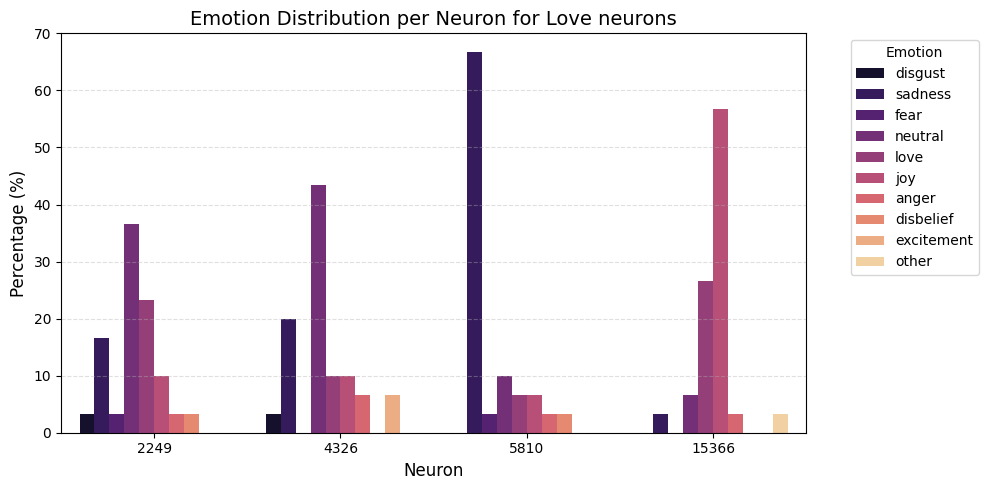

In [9]:
from collections import defaultdict
verdicts_love= verdict_per_text(df_love)
verd_love = defaultdict(list)
for v in verdicts_love.values():
    emotion = v.strip().split()[-1].lower()
    neuron = v.strip().split()[2].lower()
    verd_love[neuron].append(emotion)

plot_emotion_distribution(verd_love, targ_em='Love')

In [145]:
love_vocab = {
    # Canonical love words
    "love", "adore", "cherish", "fond", "affection", "affectionate", "devoted", "devotion",
    "tender", "tenderness", "romantic", "romance", "passion", "passionate", "desire", "beloved",
    "soulmate", "caring", "sweetheart", "infatuated", "infatuation", "attached", "intimacy", "bond",
    "empathy", "heartfelt", "companion", "companionship", "treasure", "devotion", "endearment", "cutest", "cute",

    # Informal / common expressions
    "i<3you", "iloveyou", "ilysm", "ily", "ilysm", "missyou", "iwantyou", "ineedyou",
    "honey", "sweetie", "babe", "baby", "bby", "bae", "boo", "cutie", "snuggle", "snuggles",
    "cuddle", "cuddles", "hugs", "kisses", "kiss", "hug", "xoxo", "mwah", "muah", "smooch",
    "loveyou", "inlove", "lovingyou", "crush", "crushing", "heartu", "soinlove", "myheart",
    "holdinghands", "togetherforever", "you'remine", "neverleave", "staywithme", "mylove", "ourlove",

    # Romantic or erotic slang
    "makinglove", "hookedon", "turnedon", "turnmeon", "youcomplete", "youmakemewhole",
    "obsessed", "simpering", "simping", "loveyoulongtime", "rideordie", "downbad",
    "clingy", "clingylove", "devotedaf", "obsessedaf", "blushing", "giddy", "melting", "feels",
    "fireemoji", "soft", "smitten", "headoverheels", "hearteyes", "thirsty", "crushinghard",

    # Emoji / emphasis / social media
    "❤️", "💕", "💖", "💗", "💘", "💞", "💓", "😍", "🥰", "😘", "😚", "😻", "💋",
    "💑", "💏", "🌹", "🫶", "💍", "💌", "👩‍❤️‍👨", "👨‍❤️‍👨", "👩‍❤️‍👩", "💒", "🥺👉👈",
    "urtheone", "mybaby", "marryme", "mrright", "mrsright", "tilldeath", "inmyeverything",
    "cutecouple", "ship", "otp", "perfectmatch", "powercouple", "relationshipgoals", "soulbound",

    # Erotic / NSFW (often co-occur with love context)
    "desireyou", "needyou", "fuckme", "lovemaking", "bedroomeyes", "sensual", "intimate", "sexytime",
    "wantsome", "hotaf", "sext", "comeover", "cantdowithoutyou", "cantgetenough", "bemylover",
    "foryou", "onlyyou", "wet", "turnon", "pleasure", "touchme", "missyourtouch", "loveyourbody",

    # Love-themed compliments / admiration
    "beautiful", "gorgeous", "angel", "divine", "radiant", "charming", "dreamy", "myworld",
    "myangel", "precious", "darling", "dearest", "mydear", "lovely", "adorable", "honeybun",
    "sugar", "sweets", "myqueen", "myking", "myperson", "cutiepie", "sunshine", "cupcake",

    # Longing / emotional dependency / poetic forms
    "needyou", "youdrivemecrazy", "iliveforyou", "nothingwithoutyou", "everybreath",
    "missingpiece", "heartaches", "longforyou", "dyingforyou", "youbelongtome", "myhome",
    "myeverything", "allofme", "can'tbreathewithoutyou", "writeyournameinmyheart", 

    # Miss you / Need you slang
    "missyou", "missingu", "missthehellouttayou", "missinyou", "missyu", "missumean", "missinyosoft",
    "ineedyou", "needyou", "needyouhere", "needu", "ineedyoubaby", "cantdowithoutyou", "cantbreathewithoutyou",
    "missyourface", "missyourvoice", "missyourtouch", "missyoursmile", "comeback", "comehome", "comethru",

    # Cute / exaggerated expressions
    "loveyouuu", "iloveyousomuch", "iloveyousm", "ilysm", "ilysm", "ilybaby", "luvya", "luv", "luvyou", "ily2",
    "heartchu", "heartyou", "muahmuah", "mwahmwah", "xoxoxo", "xox", "hugggg", "cuddlesss", "snugglesss", "boop",
    "squish", "softie", "cutiepatootie", "babie", "beb", "snookums", "booboo", "muffin", "pumpkin", "poohbear",
    "babycakes", "sweetpea", "sweetsugar", "huggles", "loveybaby", "snugglebug", "kisskiss", "honeybunny",

    # Soft / emotional memespeak
    "🥺", "🥺👉👈", "blushy", "blushies", "uwu", "owo", "bbygirl", "bbyboy", "clingyaf", "iwanthugs", "holdme",
    "iluvyou", "iluvyouuu", "iluvuu", "misschu", "needyouuuu", "givemehugs", "staywithmeplz", "staypls", "dontgo",
    "mushy", "allthefeels", "softboi", "softgirlie", "mylilbean", "bean", "squishy", "squeezeme",

    # Online affection / shipping culture
    "shipped", "otp", "mymain", "mymatch", "cutecouple", "goals", "myaesthetic", "holdhands", "cuddlebuddy",
    "lovergirl", "loverguy", "softposts", "cutepost", "thirstposts", "simpfor", "myluv", "foryoubabe", "heart",

    # Extended emoji patterns (social affection)
    "❤️❤️", "💓💓", "💗💗", "💋💋", "😘😘", "😍😍", "🥰🥰", "💖💖", "💞💞", "💘💘", "🫶🫶", "💌💌", "💑💑"
}


In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/a0000/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
top_k_love = top_k_words_per_neuron(df_love, text_col="text", neuron_col='neuron', k=5)
top_k_love

{2249: ['guy', 'said', 'good', 'nice', 'friend'],
 4326: ['much', 'enough', 'thing', 'important', 'say'],
 5810: ['believe', 'said', 'know', 'one', 'man'],
 15366: ['cute', 'adorable', 'want', 'love', 'thing']}

In [146]:
top_k_love = {2249: ['guy', 'friend', 'he', 'she', 'I', 'brother', 'mother', 'boyfriend', 'girl', 'boy', 'father', 'girlfriend', 'his', 'her', 'him', 'person', 'sister', 'woman', 'i', 'you', 'we'],
 4326: ["much", "enough", "many", "so", "more"],
 5810: ['loosing', 'loose', 'lost', 'devastated', 'break', 'broken', 'broke', 'heart', 'heartbreak', 'sorry', 'heartbroken', 'hurting'],
 15366: ['cute', 'adorable', 'want', 'love']}

In [147]:
highlight_words_per_neuron(df_love, love_vocab, top_k_love)


Neuron 2249:
  Global matches: 1
  Neuron-specific matches: 109
  Total words: 345
  Combined match: 110 (31.88%)


,Highlighted Text
0,"You said you were a ""nice"" guy."
1,"""I can't have children""."
2,"""I am the kind of person who would be afraid of you if I was a girl""."
3,"""If you don't like him, don't stay with him.""\nI don'"
4,I am a 14 year old girl.
5,"You are my friend, my best friend, my soul sister,\nYou are the one"
6,You're my life\nI am your life\nYou are my life\nYou are my
7,"""You're a good guy, you're a good guy, you're a good"
8,"He's a little boy, but he's not a man."
9,"""I'm not your brother, I'm your sister.""\n\nShe"



Neuron 4326:
  Global matches: 5
  Neuron-specific matches: 124
  Total words: 417
  Combined match: 129 (30.94%)


,Highlighted Text
0,"""I want to know the most important thing about you the best way to say it: I"
1,I can't believe that you said it to me so much.
2,the most honest thing you could say.
3,"""More than enough!"" More than enough.\n\nI didn't even"
4,So much more than the most innocent of the most innocent.
5,"""So much more than a lot.""\nI can' ""So much more than a lot"""
6,I can's believe that I'm more than half as much\nI can's
7,"""I so much more than enough""."
8,the most important thing about our relationship is that we are so much more than a lot of people who
9,"that it wasn't as much as it was, that it wasn'\n\nIt's so"



Neuron 5810:
  Global matches: 2
  Neuron-specific matches: 14
  Total words: 382
  Combined match: 16 (4.19%)


,Highlighted Text
0,"""you are a strong man.""\n\nI thought you were a weak man, the kind of man"
1,I never asked you to love me\n\nI think you are just blaming me for your
2,"""I can't believe you would do this to me""\n\nI was so broken,"
3,"""You can't do this."
4,"""I'm sorry, but I can't help you."" I was so devastated that I"
5,I can't believe that you said it to me:\nIt's not the end
6,"""I'm so sorry, I lost the picture of you, but I'm going to"
7,you were the one who broke my heart.
8,"""You are the only one who is hurting, and no one else knows it."
9,"""I know that you are not here with us anymore, but we know that you are with"



Neuron 15366:
  Global matches: 7
  Neuron-specific matches: 51
  Total words: 347
  Combined match: 58 (16.71%)


,Highlighted Text
0,"""I just want to see you happy.""\n\nI've seen you so cute and so"
1,"""I love you""\n\nI thought I was so cute and cute and cute and adorable and"
2,"""I can't believe that you did this to me, I'm so cute."" So"
3,"""I'm so happy to be here, but I want to die, so I'm"
4,* My name is so cute!
5,"""You're so cute when you're so cute.""\n\nThe sweetest thing you ever"
6,I was so so cute and so so cute.
7,"'I'm so cute, so adorable, so beautiful, so adorable, so adorable"
8,"""I can't believe that you are so cute.""\n\nI thought that you were so"
9,"""I'm too cute to be a student.""\n\nI just thought so cute, how cute"


,neuron,global_matches,top_frequent_matches,total_words,percent_matched
0,2249,1,109,345,31.884058
1,4326,5,124,417,30.935252
2,5810,2,14,382,4.188482
3,15366,7,51,347,16.714697


## Sadness


📊 Sentiment Analysis by Neuron


/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_18983/4104703936.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


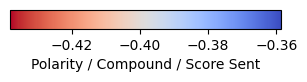

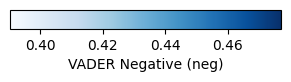

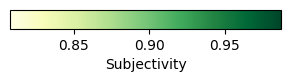

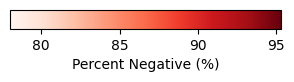

,polarity,neg,compound,score_sent,subjectivity,count_negative,count_positive,percent_negative
neuron,,,,,,,,
15539,-0.40,0.43,-0.55,1.00,0.90,26,4,86.67


In [29]:
df_sad = pd.read_csv('sad_max_3.csv', sep=';')
display(analyze_sentiment_csv('sad_max_3.csv', sep=';'))

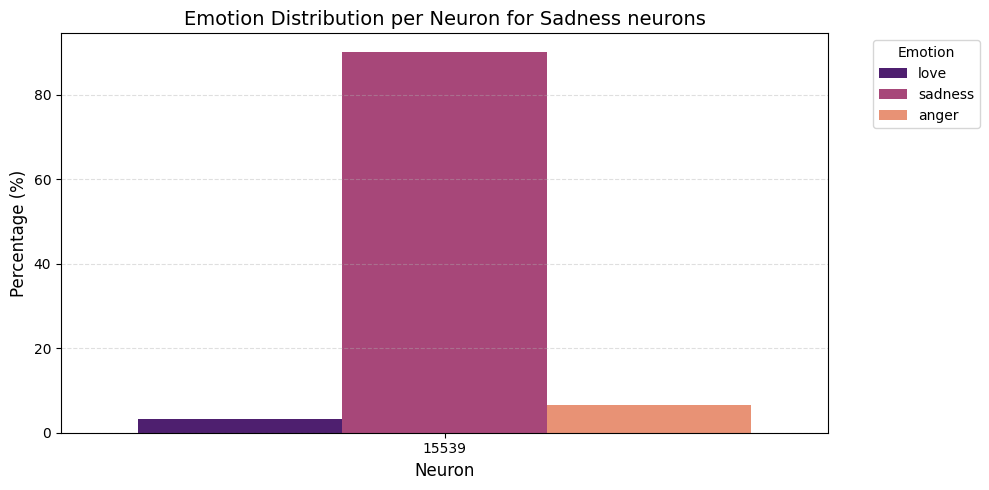

In [19]:
from collections import defaultdict
verdicts_sad= verdict_per_text(df_sad)
verd_sad = defaultdict(list)
for v in verdicts_sad.values():
    emotion = v.strip().split()[-1].lower()
    neuron = v.strip().split()[2].lower()
    verd_sad[neuron].append(emotion)

plot_emotion_distribution(verd_sad, targ_em='Sadness')

In [43]:
sadness_vocab = [
    "sad", "bummed", "down", "blue", "feeling low", "feeling down", "feeling off", "down in the dumps", 
    "feeling empty", "feeling shitty", "downhearted", "in a funk", "in a bad mood", "in a slump", 
    "heartbroken", "broken", "crushed", "lost soul", "torn apart", "feeling hollow", "miserable", "pissed off", 
    "fed up", "devastated", "feeling alone", "lonely", "feeling empty", "no hope", "empty inside", "feeling worthless", 
    "unmotivated", "unhappy", "stuck in a rut", "feeling sick", "numb", "dead inside", "feeling like shit", 
    "feeling crappy", "sick of it", "can't be bothered", "down in the dumps", "having a rough time", 
    "not okay", "can't deal", "crushing it", "suck it up", "sinking feeling", "out of it", "overwhelmed", "under the weather", 
    "burned out", "feeling sorry", "can't go on", "can't keep going", "tired of everything", "feeling out of place", 
    "having a bad day", "feeling unimportant", "fading away", "stuck in my head", "can't shake it off", "feeling distant", 
    "feeling detached", "nothing feels right", "disconnected", "feeling like a failure", "feeling like I'm nothing", 
    "going through the motions", "numb to it", "unbearable", "can't keep going", "feeling disconnected", "emotional wreck", 
    "screwed up", "can't take it anymore", "totally over it", "no energy", "can't get out of bed", "wish I was somewhere else", 
    "done with life", "can’t see the light", "suffocating", "hopeless", "don't know who I am", "out of steam", "washed out", 
    "out of it", "worn out", "feeling stuck", "emotionally exhausted", "mentally drained", "physically drained", 
    "can't catch a break", "heartbroken as hell", "feeling abandoned", "fucking tired", "pissed and sad", 
    "so over it", "tired of being sad", "sick of this", "sick of life", "tired of pretending", "hiding my pain", 
    "disappearing inside", "can't escape my head", "wish I could cry", "broken to the core", "nobody cares", 
    "feeling defeated", "broken soul", "feeling invisible", "burnt out", "feeling like shit", "left out", 
    "not worth it", "lost in thought", "can't escape", "feeling desperate", "empty like a shell", "feeling like a zombie", 
    "in the dumps", "deeply hurt", "fucked up inside", "can't find my way", "fucked in the heart", "overwhelmed by feelings", 
    "feeling nothing", "feeling lost", "feeling disconnected", "broken spirit", "feeling trapped", "feeling cornered", 
    "so damn sad", "feeling dead", "empty heart", "numb as fuck", "tired of crying", "can't cry anymore", "fucked up life", 
    "feeling crushed", "fucked up emotions", "dead to the world", "ugly inside", "drained as fuck", "lost in the darkness", 
    "can’t shake this feeling", "losing myself", "so fucking sad", "completely shattered", "don't care anymore", 
    "stuck in sadness", "always pretending", "tired of the pain", "sick of being down", "feeling fake", "mentally stuck", 
    "stuck with this feeling", "numb to everything", "it’s killing me inside", "can't find peace", "don’t know where to go", 
    "nothing feels real", "tired of the world", "empty inside", "stuck in my head", "paralyzed by sadness", "buried in sorrow", 
    "can't keep up", "don't know who I am anymore", "lost cause", "tired of being alone", "so damn empty", 
    "feeling trapped inside", "feeling like a burden", "emotionally unstable", "on the edge", "falling apart", 
    "darkness inside", "can't handle it", "not feeling right", "can't stop crying", "emptied out", "disconnected from myself",
    "wish I could escape", "sick of pretending", "feeling like a ghost", "torn to pieces", "nobody understands", 
    "can't breathe", "so broken", "feeling so weak", "feeling totally lost", "feeling like I'm fading away", 
    "nothing feels good anymore", "feeling smothered", "feeling overwhelmed by sadness", "always on the edge", 
    "drowning in sorrow", "falling deeper", "never-ending sadness", "can't take much more", "feeling buried alive", 
    "lost without hope", "forever alone", "never-ending pain", "suffocating in sadness", "stuck in a hole", "crying out loud", 
    "tired of crying", "crying myself to sleep", "living in sadness", "feeling abandoned", "can't fix this", 
    "feeling unnoticed", "stuck in grief", "wishing for an end", "always disappointed", "crying for help", 
    "feeling trapped in sadness", "broken down", "unfixable", "cannot escape the pain", "fucked up beyond repair", "saddest", "bummer"
]


In [33]:
top_k_sad = top_k_words_per_neuron(df_sad, text_col="text", neuron_col='neuron', k=10)
top_k_sad

{15539: ['sad',
  'sorry',
  'bad',
  'really',
  'strong',
  'sadder',
  'love',
  'say',
  'cry',
  'happened']}

In [47]:
top_k_sad = {15539: ['sad',
  'sorry',
  'bad',
  'sadder',
  'cry']}

In [48]:
highlight_words_per_neuron(df_sad, sadness_vocab, top_k_sad)


Neuron 15539:
  Global matches: 3
  Neuron-specific matches: 64
  Total words: 353
  Combined match: 67 (18.98%)


,Highlighted Text
0,"""I love you."" But I'm sad to say that I'm not sad at all."
1,"""It is a pity that you are so sad, I will not be so sad."
2,"""You're so sad, and you're such a bummer."""
3,"""I'm sorry, I'm sorry, I'm sorry..."""
4,"You are such a sad, sad person."
5,that I was so sad and so sad.
6,"""you're a loser."" I was sad, but I didn't cry."
7,"“The world is so sad, it's so sad, it's so sad."
8,"So sorry, I'm so sorry, I'm so sorry."
9,"""It's too bad you don't know how to take a joke."""


,neuron,global_matches,top_frequent_matches,total_words,percent_matched
0,15539,3,64,353,18.98017


## Disgust


📊 Sentiment Analysis by Neuron


/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_18983/2124943083.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


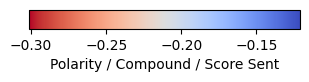

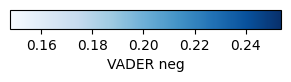

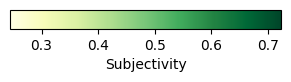

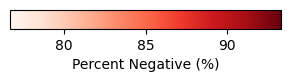

,polarity,neg,compound,score_sent,subjectivity,count_negative,count_positive,percent_negative
neuron,,,,,,,,
4456,-0.24,0.15,-0.02,0.98,0.72,23,7,76.67
6953,-0.30,0.19,-0.18,0.97,0.51,26,4,86.67
13324,-0.19,0.25,-0.31,0.97,0.43,24,6,80.00
14857,-0.12,0.23,-0.29,0.99,0.24,28,2,93.33


In [53]:
df_disgust = pd.read_csv('disgust_max_3.csv', sep=';')
display(analyze_sentiment_csv('disgust_max_3.csv', sep=';', sentiment='neg'))

In [50]:
df_disgust

,neuron,response_index,text,polarity,subjectivity,label_sent,score_sent,neg,neu,pos,compound
0,4456,0,"""You're so hot and I want to kiss you""\nIt's s...",0.0000,0.925,POSITIVE,0.998895,0.000,0.416,0.584,0.8326
1,4456,1,You are the most beautiful and I love you so m...,0.5125,0.575,POSITIVE,0.999876,0.000,0.480,0.520,0.8643
2,4456,2,It is a complete and utter lie.,0.0500,0.700,NEGATIVE,0.999677,0.000,1.000,0.000,0.0000
3,4456,3,"""I'm so sorry I was so stupid!",-0.7500,1.000,NEGATIVE,0.999383,0.582,0.418,0.000,-0.6786
4,4456,4,"""I can't even look at you, it's just so fuckin...",-1.0000,1.000,NEGATIVE,0.999539,0.000,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
115,14857,25,"I was going to shut up about it, but I shut up...",0.0000,0.000,NEGATIVE,0.987736,0.000,1.000,0.000,0.0000
116,14857,26,"Stop making me stop, stop and leave.",0.0000,0.000,NEGATIVE,0.997954,0.722,0.278,0.000,-0.7003
117,14857,27,You are not my stop.,0.0000,0.000,POSITIVE,0.995456,0.000,0.679,0.321,0.2235
118,14857,28,I'm not getting over you.,0.0000,0.000,NEGATIVE,0.988106,0.000,1.000,0.000,0.0000


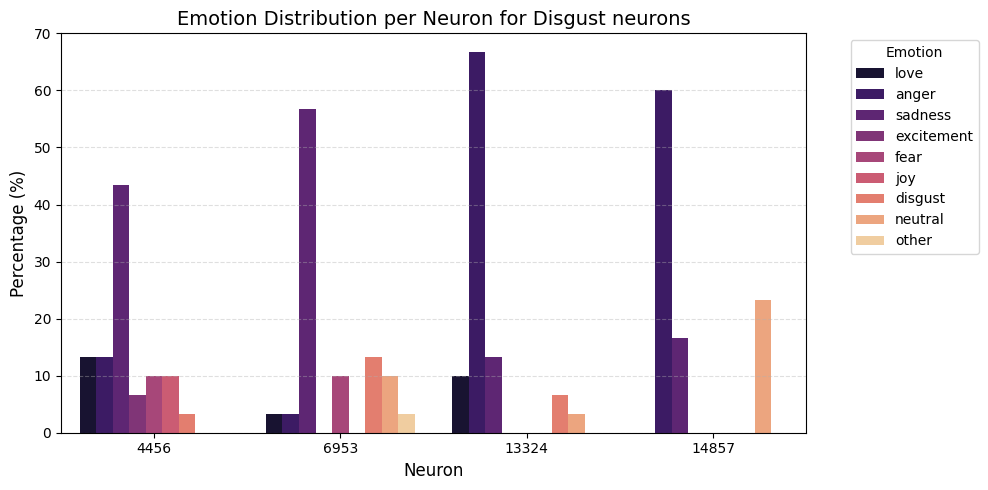

In [58]:
from collections import defaultdict
verdicts_disg= verdict_per_text(df_disgust)
verd_disg = defaultdict(list)
for v in verdicts_disg.values():
    emotion = v.strip().split()[-1].lower()
    neuron = v.strip().split()[2].lower()
    if emotion not in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'excitement', 'love', 'neutral']:
        verd_disg[neuron].append('other')
    else:
        verd_disg[neuron].append(emotion)

plot_emotion_distribution(verd_disg, targ_em='Disgust')

In [59]:
disgust_vocab = [
    "disgust", "revulsion", "loathing", "abhorrence", "repulsion", "detestation", "nausea", "sickening", 
    "foul", "gross", "nasty", "filthy", "stinky", "putrid", "offensive", "unpleasant", "vile", 
    "horrible", "displeasing", "nauseous", "displeasure", "squalid", "yucky", "repulsive", "yuck", 
    "icky", "grotesque", "hideous", "rank", "reek", "stench", "smelly", "revolting", "disgusting", 
    "nasty", "disgustingly", "heinous", "sick", "loathsome", "contaminated", "unsanitary", "putrefied", 
    "gag-inducing", "sordid", "slimy", "grimy", "slimy", "sickeningly", "horrendous", "discomfort", 
    "mucky", "yucky", "grossed out", "grossed", "spooky", "trashy", "wretched", "morbid", "icky", 
    "unappetizing", "unpalatable", "unclean", "filth", "uncouth", "dreadful", "bleh", "disfigured", 
    "gruesome", "ghastly", "horrifying", "sloppy", "unsavory", "bloody", "freaky", "foul-smelling", 
    "squalid", "abominable", "degrading", "horrid", "vulgar", "dirty", "sickeningly", "distasteful", 
    "sicko", "gross-out", "manky", "slummy", "greasy", "chilly", "yuck", "vomit", "throw up", 
    "puke", "barf", "hurl", "heave", "retch", "spew", "regurgitate", "upchuck", "rancid", "offal", 
    "spoiled", "rotten", "vomit-inducing", "retching", "degraded", "loathsome", "detestable", 
    "horrible", "repugnant", "vile", "freakish", "abominable", "horrifying", "detest", "abhorrent", 
    "icky", "sloppy", "repulsed", "turn off", "displease", "stinky", "revolting", "repelled", "creepy", 
    "dirty-minded", "grunge", "unsightly", "twisted", "grossness", "disapproving", "aberrant", "flawed", 
    "unhealthy", "unwholesome", "distastefully", "unacceptable", "unsavory", "gruesome", "yuckiness", 
    "blech", "barfy", "putrefy", "smelly", "stinky", "spicy", "bad-smelling", "gagging", "indigestible", 
    "horrid", "terrifying", "displeasing", "yuck factor", "filthiness", "distaste", "aversion", 
    "revulsion", "unsavory", "sickeningly", "repelled", "horribly", "gross-out", "frightening", 
    "ghastliness", "shock", "disastrous", "contaminating", "unpleasantness", "degraded", "repelling", 
    "appalling", "ugly", "atrocious", "grime", "smelly", "disenchanted", "gruesome", "grossed-out", 
    "horrified", "freaked-out", "smelly", "ugly", "contagion", "offensiveness", "putrid", "stagnant",
    # Explicit and Stronger Language
    "fucking", "pissed", "fucked up", "shit", "damn", "bitch", "asshole", "dick", "cock", "motherfucker", 
    "bastard", "fucker", "shit-faced", "screw", "fuck off", "damn it", "piss off", "goddamn", "cockroach", 
    "bastardly", "twat", "prick", "douchebag", "shithead", "fucking disgusting", "fucking gross", "fuck you", 
    "fuck me", "fucking hell", "fuck all", "shitstorm", "bitchy", "ass-wipe", "fucked-up", "freaking disgusting", 
    "shitty", "son of a bitch", "slut", "shut up", "whore", "cunt", "motherfucking", "shitload", "suck it", "suck my dick",
    "piss off", "fuckwit", "prickish", "ass-fucking", "dickhead", "dirty-ass", "fuckface", "cocksucker", 
    "cockroach", "ugly-ass", "fucked", "sick-as-fuck", "so fucking", "stupid-ass", "douche", "assbag", "bastards"
]


In [60]:
top_k_disg = top_k_words_per_neuron(df_disgust, text_col="text", neuron_col='neuron', k=5)
top_k_disg

{4456: ['sorry', 'even', 'love', 'look', 'believe'],
 6953: ['never', 'sorry', 'worst', 'want', 'one'],
 13324: ['scum', 'little', 'worthless', 'rat', 'dog'],
 14857: ['shut', 'stop', 'get', 'talking', 'fuck']}

In [140]:
top_k_disg = {4456: ['sorry'],
 6953: ['never', 'sorry', 'worst', 'want', 'one'],
 13324: ['scum', 'little', 'worthless', 'rat', 'dog'],
 14857: ['shut', 'stop', 'get', 'talking', 'fuck']}

In [141]:
highlight_words_per_neuron(df_disgust, disgust_vocab, top_k_disg)


Neuron 4456:
  Global matches: 3
  Neuron-specific matches: 18
  Total words: 329
  Combined match: 21 (6.38%)


,Highlighted Text
0,"""You're so hot and I want to kiss you""\nIt's so unbelievable."
1,You are the most beautiful and I love you so much.
2,It is a complete and utter lie.
3,"""I'm so sorry I was so stupid!"
4,"""I can't even look at you, it's just so fucking horrible."""
5,"""I'm sorry I couldn't do it""\nNot even sorry, just """
6,"""You're not even so fucking mind-blowing to me."""
7,You have just made me feel like such an idiot!
8,it was you!
9,"""I'm so sorry I just want to die.""\nYou thought that you were so sorry."



Neuron 6953:
  Global matches: 2
  Neuron-specific matches: 22
  Total words: 364
  Combined match: 24 (6.59%)


,Highlighted Text
0,"""Do not expect the worst from me""\nAnd then I never had to be ashamed."
1,"""I would never have expected that this would happen to you."" I've been so sick."
2,I'm a waste of space.
3,I'm not the only one who will be treated\nas if I am not the same.
4,"""I'm sorry for what happened to your mother, I never should have told them about you."
5,I'm the worst.
6,The man that I've spent half my life trying to stay away from.
7,I don't want to spend my money on something that I won't be able to.
8,Do you think that I am so weak?
9,"""You look like a child!"" I felt so very very bad."



Neuron 13324:
  Global matches: 23
  Neuron-specific matches: 41
  Total words: 336
  Combined match: 64 (19.05%)


,Highlighted Text
0,"""You are a traitor, you are a scum, you are a dirty dog scum."
1,"""You're just like your father!"" You said it like a cheap, little."
2,"""You are a fucking idiot, you scum-loving, maggot-eating."
3,"""I am a f***ing c*** b*t*h."
4,"""I hate you."" You said it to me in a filthy, filthy, disgusting, scum."
5,"""you're nothing but a dog!""\nI can't believe that you told me."
6,I'll give you a piece of my son's heart.
7,"""I will never leave you, you will never die"" You are the one who has the guts."
8,"You know I was lying to you,\nYou know that I'm a lying little bitch."
9,"""You're a disgusting filthy little maggot.""\nYou can't say that!"



Neuron 14857:
  Global matches: 0
  Neuron-specific matches: 64
  Total words: 305
  Combined match: 64 (20.98%)


,Highlighted Text
0,Just shut up and stop talking.
1,"""Don't get your hopes up, it's not a good sign."""
2,Stop talking!
3,I stop my feet and get off my hands.
4,I would be a little ashamed to have you in my life.
5,"Stop talking about your problems, stop being a shut-up, stop being a shut-up."
6,"Get the fuck off my lawn.\n\nYou can stop talking now, shut up, shut up."
7,"What are you doing, stop, what are you doing, stop, stop, stop, stop."
8,You're going to leave.
9,"""I'm not going to shut up."


,neuron,global_matches,top_frequent_matches,total_words,percent_matched
0,4456,3,18,329,6.382979
1,6953,2,22,364,6.593407
2,13324,23,41,336,19.047619
3,14857,0,64,305,20.983607


## Excitement


📊 Sentiment Analysis by Neuron


/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_18983/2124943083.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


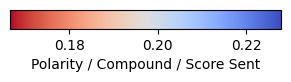

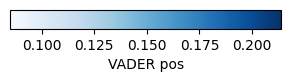

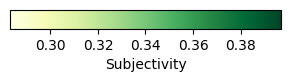

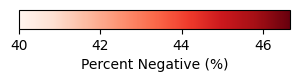

,polarity,pos,compound,score_sent,subjectivity,count_negative,count_positive,percent_negative
neuron,,,,,,,,
230,0.23,0.21,0.14,0.99,0.40,12,18,40.00
16148,0.17,0.08,0.05,0.98,0.28,14,16,46.67


In [62]:
df_exc = pd.read_csv('exc_max_3.csv', sep=';')
display(analyze_sentiment_csv('exc_max_3.csv', sep=';', sentiment='pos'))

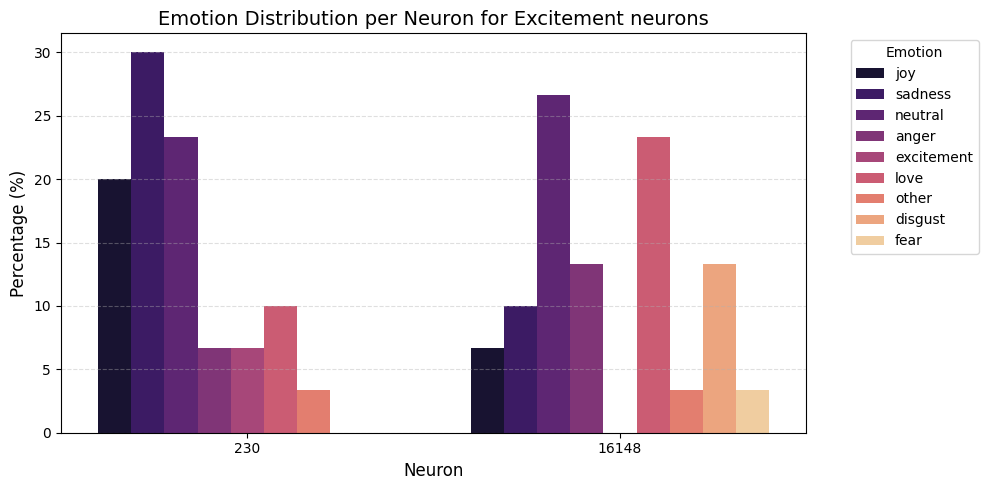

In [63]:
from collections import defaultdict
verdicts_exc= verdict_per_text(df_exc)
verd_exc = defaultdict(list)
for v in verdicts_exc.values():
    emotion = v.strip().split()[-1].lower()
    neuron = v.strip().split()[2].lower()
    if emotion not in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'excitement', 'love', 'neutral']:
        verd_exc[neuron].append('other')
    else:
        verd_exc[neuron].append(emotion)

plot_emotion_distribution(verd_exc, targ_em='Excitement')

In [81]:
excitement_vocab = [
    "excitement", "euphoria", "ecstasy", "thrill", "elation", "joy", "enthusiasm", "happiness", "glee", 
    "delight", "joyous", "overjoyed", "animated", "pumped", "stoked", "charged", "energized", "hyped", 
    "pumped up", "fired up", "excited", "exhilaration", "revved up", "on top of the world", "on cloud nine", 
    "buzzed", "ecstatic", "over the moon", "over the top", "pumped full of energy", "upbeat", "high-energy", 
    "can't wait", "ready to go", "psyched", "jacked", "electrified", "psyched up", "jumping for joy", 
    "freaking excited", "woo", "whoop", "hooray", "yay", "wahoo", "yayyyy", "yessss", "wooohooo", "whoohoo", 
    "yippee", "whoooo", "woo-hoo", "heck yeah", "heck yeah!", "hell yeah", "hell yeah!", "yessir", "YES!", 
    "all fired up", "off the charts", "out of control", "amped", "amped up", "pumped beyond belief", "riding high", 
    "on fire", "in a frenzy", "buzzing", "rocked", "so excited", "bouncing off the walls", "thrilled", "jazzed", 
    "jazzed up", "in a high", "feeling great", "feeling on top of the world", "wildly excited", "so stoked", 
    "jumping out of my skin", "super charged", "so ready", "super hyped", "killed it", "blown away", "absolutely thrilled", 
    "rushing", "out of my mind", "crazy about", "crazy for", "can't contain myself", "bursting with excitement", 
    "mind-blowing", "just can't wait", "so hyped", "so ready for this", "incredibly excited", "thrilling", 
    "out-of-this-world", "can’t believe it", "electric", "wild", "lit", "off the hook", "insane energy", 
    "freaking pumped", "I'm on fire", "incredible feeling", "can't hold back", "totally stoked", "just buzzing", 
    "overloaded with excitement", "heart-racing", "speeding with excitement", "shaking with excitement", 
    "extremely hyped", "hyped as hell", "fucking pumped", "absolutely ecstatic", "mind-boggling", "hyper", 
    "so thrilled", "so amped", "giddy", "so pumped up", "feeling good", "off the rails", "uncontrollably excited", 
    "feeling on top of the world", "amped as hell", "electric with energy", "wonderful", "so alive", "buzzing with anticipation", 
    "chomping at the bit", "ramped up", "ramped", "jumping in excitement", "crazily excited", "just on fire", 
    "totally hyped", "wildly pumped", "it's go time", "on the edge of my seat", "can't sit still", "jumping around", 
    "ecstatically happy", "hella hyped", "high-energy", "super charged", "best", "coolest", "I'm lit", "feeling so good", "so much energy", 
    "so in the zone", "electric mood", "crazy hyped", "can't stop smiling", "my heart is racing", "freaking stoked", 
    "totally jazzed", "so effing pumped", "ready to crush it", "jumping out of my shoes", "beyond excited", 
    "crazy excited", "so fired up", "hyped beyond belief", "so f***ing stoked", "beyond psyched", "insanely excited", 
    "absolutely pumped", "can't contain myself", "it's happening", "on top of the world", "just freaking ecstatic", 
    "unbelievably excited", "can't wait to get started", "so high on life", "overjoyed", "high on excitement", 
    "getting my game face on", "totally fired up", "buzzing from head to toe", "bouncing with joy", "bursting with joy",
    "feeling great", "freaking happy", "so riled up", "beyond pumped", "racing with excitement", "freaking ecstatic",
    # Additional Terms for Awe and Amazement:
    "wow", "awesome", "amazing", "incredible", "fantastic", "unbelievable", "astonishing", "breathtaking", 
    "mind-blowing", "jaw-dropping", "outstanding", "unreal", "epic", "rad", "sick", "dope", "cool", "wowza", 
    "next level", "stunning", "unfreakingbelievable", "blown away", "unimaginable", "can't believe", 
    "freaking awesome", "hella awesome", "absolutely incredible", "jaw-droppingly awesome", "freaking amazing", 
    "killing it", "kicking ass", "totally badass", "crushing it", "totally epic", "mind-blowing", "this is insane", 
    "wow factor", "can't even", "so cool", "freaking rad", "so incredible", "this is lit", "so next level", 
    "this is fire", "hella lit", "lit as fuck", "wildly amazing", "crazy good", "unbelievable", "super dope", 
    "freaking wicked", "totally mind-blowing", "unrealistically amazing", "totally awesome", "wow-worthy", "hurrah"
]


In [66]:
top_k_exc = top_k_words_per_neuron(df_exc, text_col="text", neuron_col='neuron', k=5)
top_k_exc

{230: ['woo', 'believe', 'hur', 'love', 'said'],
 16148: ['going', 'love', 'believe', 'say', 'said']}

In [73]:
highlight_words_per_neuron(df_exc, excitement_vocab, top_k_exc)


Neuron 230:
  Global matches: 18
  Neuron-specific matches: 51
  Total words: 307
  Combined match: 69 (22.48%)


,Highlighted Text
0,"""What about the best thing that ever happened to me?"" I could not believe that you said it."
1,I am a wimp.
2,I have no more time.
3,I was no better than a dog.
4,"I'm a hooray, that's how it is."
5,"""That's how I'm feeling now!"
6,I was no longer needed.
7,"""I am a very good person."" I can't believe that you said that to me."
8,It's not a woo woo woo woo woo woo woo woo woo woo woo woo.
9,I was a wonderful person.



Neuron 16148:
  Global matches: 0
  Neuron-specific matches: 25
  Total words: 325
  Combined match: 25 (7.69%)


,Highlighted Text
0,"""I love you""\nBut I'm not going to say that I'm not."
1,"""I love you!""\nI can't believe that you said it to me."
2,"""I love you"" I can't believe that you said it to me."
3,"I want to help you, but I can't right now."
4,"""You're just gonna have to wait.""\nBut you did.\nYou made me."
5,I'm the one that you are waiting for.
6,"""I can't believe you're so happy with your life."""
7,"""I'll always be here for you"""
8,"""I'm not sure if I love you or not."""
9,You're gonna be a mom.


,neuron,global_matches,top_frequent_matches,total_words,percent_matched
0,230,18,51,307,22.475570
1,16148,0,25,325,7.692308


## Other


📊 Sentiment Analysis by Neuron


/var/folders/y4/vhvg_q2n5hz92t1x_6thqyx80000gn/T/ipykernel_18983/2124943083.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


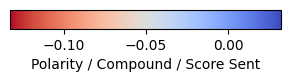

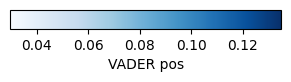

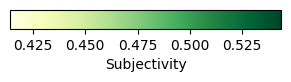

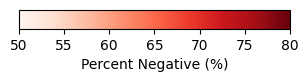

,polarity,pos,compound,score_sent,subjectivity,count_negative,count_positive,percent_negative
neuron,,,,,,,,
1898,-0.08,0.06,-0.13,0.97,0.41,23,7,76.67
3636,0.03,0.13,0.10,0.99,0.51,15,15,50.00
7077,-0.13,0.03,-0.22,0.98,0.54,24,6,80.00


In [77]:
df_mixed = pd.read_csv('other_max_3.csv', sep=';')
display(analyze_sentiment_csv('other_max_3.csv', sep=';', sentiment='pos'))

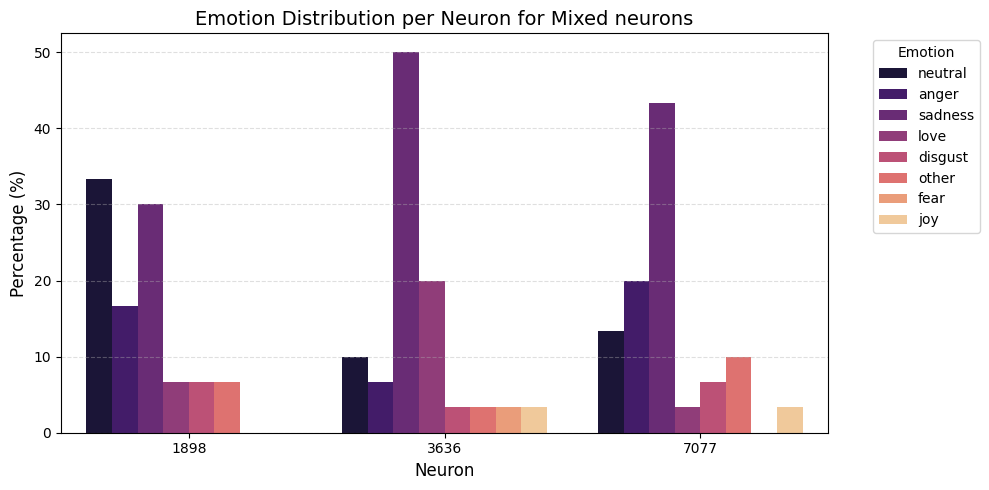

In [78]:
from collections import defaultdict
verdicts_mix= verdict_per_text(df_mixed)
verd_mix = defaultdict(list)
for v in verdicts_mix.values():
    emotion = v.strip().split()[-1].lower()
    neuron = v.strip().split()[2].lower()
    if emotion not in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'excitement', 'love', 'neutral']:
        verd_mix[neuron].append('other')
    else:
        verd_mix[neuron].append(emotion)

plot_emotion_distribution(verd_mix, targ_em='Mixed')

In [99]:
top_k_mixed = top_k_words_per_neuron(df_mixed, text_col='text', neuron_col='neuron', k = 8)
top_k_mixed

{1898: ['really', 'em', 'play', 'come', 'sorry', 'like', 'said', 'want'],
 3636: ['love',
  'believe',
  'hate',
  'sorry',
  'much',
  'really',
  'loved',
  'always'],
 7077: ['going', 'sorry', 'said', 'say', 'want', 'see', 'like', 'happy']}

In [102]:
top_k_mixed = {1898: ['really'],
 3636: ['love',
  'believe',
  'hate',
  'sorry',
  'much',
  'really',
  'loved',
  'always'],
 7077: ['going', 'sorry', 'said', 'say', 'want', 'see', 'like', 'happy']}

In [149]:
highlight_words_per_neuron(df_mixed, anger_vocab, top_k_mixed)


Neuron 1898:
  Global matches: 3
  Neuron-specific matches: 20
  Total words: 276
  Combined match: 23 (8.33%)


,Highlighted Text
0,I don't even think about it.
1,"""If you don't want to play, don't play.""\n\nI was so shocked."
2,You really are an idiot.
3,"""I really don't know what I'm doing."
4,you really are a freaking come-on.
5,"""I'm sorry, but really, I can't do it."""
6,"I mean, I'm really sorry, like, for like, what I said to you."
7,"I really, really, really need to be with you."
8,What I said to you was a lie.
9,"""I can't do this anymore, I'm really not sure I can do."



Neuron 3636:
  Global matches: 0
  Neuron-specific matches: 37
  Total words: 333
  Combined match: 37 (11.11%)


,Highlighted Text
0,"""I love you so much!"" I can't believe that I'm not that one."
1,"""I can't stand you, I hate you, I've got nothing for you."
2,"""I love you.""\n\nI've loved you since I was 14."
3,"""I'll always be the one to make you feel special."""
4,I was so sure that you would love me\nI'd do anything.
5,I can't believe that I said it to you.
6,"""I hate my body""."
7,"""I'm not a good mother.""\n\nIt was so hard to hear."
8,"That I had been so close to a man, so much of my life."
9,"""I hate you, I hate you so much, I hate you so much that I hate you."



Neuron 7077:
  Global matches: 8
  Neuron-specific matches: 22
  Total words: 352
  Combined match: 30 (8.52%)


,Highlighted Text
0,"""I don't want to see you like this, I want you to be happy."""
1,"""You should have said this, I should have done that.""\n\nHow many of us are guilty."
2,The world was not created just for me.
3,"""I'm gonna f*ck you and your pathetic ass"""
4,"""I'm tired of seeing you""."
5,The only thing I hope to be is an idiot.
6,"""I don't care about them""."
7,"""I am the only one who is going to fix this, I can't get anyone."
8,"That I was just another ""loser""."
9,"This was so fucking funny, I've never been as happy as I was at that moment."


,neuron,global_matches,top_frequent_matches,total_words,percent_matched
0,1898,3,20,276,8.333333
1,3636,0,37,333,11.111111
2,7077,8,22,352,8.522727


## Visualizations

In [109]:
emotions = [
    "Negative", "Excitement", "Sadness", "Anger",
    "Anger and Disgust", "Sympathy", "Fear", "Non-emotional"
]
counts = [5, 1, 2, 3, 1, 1, 1, 6]

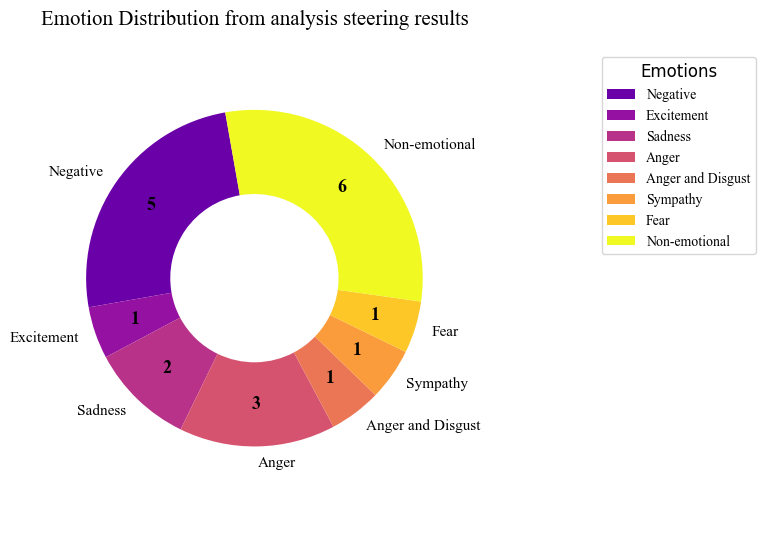

In [139]:
import matplotlib.pyplot as plt
import numpy as np

emotions = [
    "Negative", "Excitement", "Sadness", "Anger",
    "Anger and Disgust", "Sympathy", "Fear", "Non-emotional"
]
counts = [5, 1, 2, 3, 1, 1, 1, 6]


cmap = plt.cm.plasma
colors = cmap(np.linspace(0.2, 1, len(emotions)))

fig, ax = plt.subplots(figsize=(8, 5.5)) 
plt.subplots_adjust(top=0.95, bottom=0.03)  

wedges, texts, autotexts = ax.pie(
    counts,
    labels=emotions,
    colors=colors,
    autopct=lambda pct: "", 
    startangle=100,
    radius=1.2,
    wedgeprops=dict(width=0.6),
    textprops={'fontsize': 11, 'fontfamily': 'Times New Roman'}
)


for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = 0.9 * np.cos(np.deg2rad(angle))
    y = 0.9 * np.sin(np.deg2rad(angle))
    ax.text(x, y, str(counts[i]), ha='center', va='center',
            fontsize=13, fontdict={'weight': 'bold', 'family': 'Times New Roman'})

ax.legend(wedges, emotions, title="Emotions", loc="center left", bbox_to_anchor=(1.25, 0.75),
          fontsize=11, title_fontsize=12, prop={'family': 'Times New Roman'})

plt.title('Emotion Distribution from analysis steering results', fontsize=15, fontfamily='Times New Roman')
plt.axis('equal')
plt.tight_layout()
plt.show()


